# Qualitative Evaluation Picker

In this notebook, some instances of the produced results are picked for qualitative evaluation

In [1]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [2]:
all_original_results = pd.read_csv('../results/allResults.csv')
all_custom_results = pd.read_csv('../results/allResults-custom.csv')

all_original_results.rename(columns={'index': 'id'}, inplace=True)
all_custom_results.rename(columns={'index': 'id'}, inplace=True)

There are 6 models: 
1. explanation
2. label
3. label-explanation

4. explanation-custom
5. label-custom
6. label-explanation-custom

In [3]:
def exportSpecificRows(results, ids):
    '''Exports the rows with the given ids to a csv file
        
    Args:
        results: pandas dataframe with the results
        ids: list of ids to be exported
        filename: name of the file to be exported
    
    '''
    # results[results['id'].isin(ids)].sort_values(by=['id']).to_excel(filename, index=False)
    return results[results['id'].isin(ids)].sort_values(by=['id'])
    

In [4]:
# Manually added the indexes here after they were generated by the sampler
ids_set_Amber_Leo = [259, 602, 1122, 1127, 1155, 1228, 1292, 1612, 1865, 2424, 2489, 3043, 3254, 3441, 3858, 4252, 4537, 4731, 4757,
                     4833, 5839, 5880, 5899, 6071, 6191, 6395, 6560, 7044, 7072, 7208, 7212, 7321, 7562, 7714, 8004, 8127, 8714, 8825, 9656, 9754]
ids_set_Lorenzo_Phillip = [148, 691, 793, 1289, 1296, 1545, 1625, 1780, 1847, 2187, 2316, 2553, 2622, 2646, 2670, 2676, 3230, 3272,
                           3401, 3550, 4211, 4584, 4906, 5015, 5374, 6278, 6670, 6878, 7060, 7465, 7480, 7743, 8347, 8770, 8827, 9295, 9488, 9575, 9656, 9714]

if not os.path.exists('../results/qualitativeEvaluation'):
    os.makedirs('../results/qualitativeEvaluation')

amber_leo_original_set = exportSpecificRows(
    all_original_results, ids_set_Amber_Leo)
lorenzo_phillip_original_set = exportSpecificRows(
    all_original_results, ids_set_Lorenzo_Phillip)

amber_leo_custom_set = exportSpecificRows(
    all_custom_results, ids_set_Amber_Leo)
lorenzo_phillip_custom_set = exportSpecificRows(
    all_custom_results, ids_set_Lorenzo_Phillip)

amber_leo_original_set.to_excel(
    '../results/qualitativeEvaluation/Amber_Leo_original.xlsx', index=False)
lorenzo_phillip_original_set.to_excel(
    '../results/qualitativeEvaluation/Lorenzo_Phillip_original.xlsx', index=False)

amber_leo_custom_set.to_excel(
    '../results/qualitativeEvaluation/Amber_Leo_custom.xlsx', index=False)
lorenzo_phillip_custom_set.to_excel(
    '../results/qualitativeEvaluation/Lorenzo_Phillip_custom.xlsx', index=False)

In [5]:
def sampler(dataset, column_to_sort, samples_per_quartile = 2):
    '''Sample examples from each quartile of a dataset based on a column_to_sort
        
    Args:
        dataset: pandas dataframe with the results
        column_to_sort: column to sort the dataset by to use for quartile sampling
        samples_per_quartile: number of samples to take from each quartile
    
    Returns:
        pandas dataframe with the sampled examples
    '''
    # Quartile 1
    q1 = dataset[dataset[column_to_sort] <=
                    dataset[column_to_sort].quantile(0.25)]
    q1 = q1.sample(n=samples_per_quartile)

    # Quartile 2
    q2 = dataset[(dataset[column_to_sort] > dataset[column_to_sort].quantile(
        0.25)) & (dataset[column_to_sort] <= dataset[column_to_sort].quantile(0.5))]
    q2 = q2.sample(n=samples_per_quartile)

    # Quartile 3

    q3 = dataset[(dataset[column_to_sort] > dataset[column_to_sort].quantile(
        0.5)) & (dataset[column_to_sort] <= dataset[column_to_sort].quantile(0.75))]
    q3 = q3.sample(n=samples_per_quartile)

    # Quartile 4
    q4 = dataset[dataset[column_to_sort] >
                    dataset[column_to_sort].quantile(0.75)]
    q4 = q4.sample(n=samples_per_quartile)

    # Return concatenated dataframe

    return pd.concat([q1, q2, q3, q4])
    

In [6]:
# Pick num_samples_per_quartile examples from each quartile based on neural score
# We use the explanation model instead of label-explanation. Hopefully that does not have a big impact for the sorting.
custom_sampled_results = sampler(all_custom_results, 'rug-nlp-nli/flan-base-nli-explanation-custom_neural_score', samples_per_quartile = 10)
#Pick the examplees with the same id from the original results
original_sampled_results = all_original_results[all_original_results['id'].isin(custom_sampled_results['id'])]    

masked_original_results = original_sampled_results[['id', 'premise', 'hypothesis',
                                      'label',
                                      'rug-nlp-nli/flan-base-nli-explanation_prediction', 
                                      'rug-nlp-nli/flan-base-nli-label-explanation_prediction'
                                      ]].copy()

masked_custom_results = custom_sampled_results[['id', 'premise', 'hypothesis',
                                      'label',
                                      'rug-nlp-nli/flan-base-nli-explanation-custom_prediction', 
                                      'rug-nlp-nli/flan-base-nli-label-explanation-custom_prediction'
                                      ]].copy()

# Rename the label column as correct_label for clarity
masked_original_results.rename(columns={'label': 'correct_label'}, inplace=True)
# Hide model names, to reduce bias in the qualitative evaluation
masked_original_results.rename(columns={'rug-nlp-nli/flan-base-nli-explanation_prediction': 'prediction_1'}, inplace=True)
masked_original_results.rename(columns={'rug-nlp-nli/flan-base-nli-label-explanation_prediction': 'prediction_2'}, inplace=True)

# Rename the label column as correct_label for clarity
masked_custom_results.rename(columns={'label': 'correct_label'}, inplace=True)
# Hide model names, to reduce bias in the qualitative evaluation
masked_custom_results.rename(columns={'rug-nlp-nli/flan-base-nli-explanation-custom_prediction': 'prediction_3'}, inplace=True)
masked_custom_results.rename(columns={'rug-nlp-nli/flan-base-nli-label-explanation-custom_prediction': 'prediction_4'}, inplace=True)

# Order based on id, so that it's easy to compare the two tables.
masked_original_results.sort_values(by=['id'], inplace=True)
masked_custom_results.sort_values(by=['id'], inplace=True)

In [7]:
# Make a copy of the original results to add the custom results to.
all_qualitative_results = masked_original_results.copy()

# Copy prediction_3 and Prediction_4 to the original results
all_qualitative_results['prediction_3'] = masked_custom_results['prediction_3'].to_numpy()
all_qualitative_results['prediction_4'] = masked_custom_results['prediction_4'].to_numpy()

In [8]:
# Export the two dataframes to two csvs
all_qualitative_results.to_csv('../results/results_for_qual_evaluation.csv')

In [9]:
# Print the results from the original models, that use the full dataset
masked_original_results

,id,premise,hypothesis,correct_label,prediction_1,prediction_2
7695,62,People jump over a mountain crevasse on a rope.,Some people look visually afraid to jump.,neutral,People jump over a mountain crevasse on a rope...,neutral: People jump over a mountain crevasse ...
5094,113,A crowd of people looking up at 3 people on th...,The crowd on the ground is watching 3 people o...,entailment,The crowd on the ground is watching 3 people o...,entailment: A crowd of people looking up at 3 ...
2062,115,A woman working long hours.,A woman is working in a factory.,neutral,Just because a woman is working long hours doe...,neutral: Just because a woman is working long ...
6458,132,A guy riding a motorcycle near junk cars,The man is test driving a motorcycle to decide...,neutral,Just because a guy is riding a motorcycle near...,neutral: A guy riding a motorcycle near junk c...
5504,283,"Girl in a red coat, blue head wrap and jeans i...",A girl outside plays in the snow.,entailment,Making a snow angel is a form of playing in th...,entailment: Making a snow angel is a form of p...
5030,429,A man wearing a red vest is walking past a bla...,The man wearing the vest is sitting on the sofa.,contradiction,The man cannot be walking and sitting at the s...,contradiction: The man cannot be walking and s...
9522,708,A family walking with a soldier.,The barber cuts a man's hair.,contradiction,A family walking with a soldier is not the sam...,contradiction: A family walking with a soldier...
4059,1111,People are standing next to a chain link fence.,The people are outside.,entailment,chain link fence implies outside.,entailment: chain link fence implies outside.
8473,1231,The firemen and women wearing blue gloves have...,The person under the blanket is dead.,neutral,Just because a person is lying on ground banda...,neutral: Just because a person is lying on gro...
1048,1912,A man stands on one hand in the street while a...,The kid is standing on two hands in the street.,contradiction,A man is not a kid.,contradiction: A man is not a kid.


In [10]:
# Print the results from the custom models, that use the cleaned dataset
masked_custom_results

,id,premise,hypothesis,correct_label,prediction_3,prediction_4
7403,62,People jump over a mountain crevasse on a rope.,Some people look visually afraid to jump.,neutral,Just because people jump over a mountain creva...,neutral: People jump over a mountain crevasse ...
1729,113,A crowd of people looking up at 3 people on th...,The crowd on the ground is watching 3 people o...,entailment,A crowd of people looking up at 3 people on th...,contradiction: The crowd cannot be looking up ...
2070,115,A woman working long hours.,A woman is working in a factory.,neutral,Just because a woman is working long hours doe...,neutral: Just because a woman is working long ...
6401,132,A guy riding a motorcycle near junk cars,The man is test driving a motorcycle to decide...,neutral,A guy riding a motorcycle near junk cars is no...,neutral: A guy riding a motorcycle near junk c...
5477,283,"Girl in a red coat, blue head wrap and jeans i...",A girl outside plays in the snow.,entailment,Making a snow angel is a form of playing in th...,entailment: Making a snow angel is a form of p...
5014,429,A man wearing a red vest is walking past a bla...,The man wearing the vest is sitting on the sofa.,contradiction,The man cannot be walking and sitting at the s...,contradiction: The man cannot be walking and s...
9498,708,A family walking with a soldier.,The barber cuts a man's hair.,contradiction,A family walking with a soldier is not the sam...,contradiction: A family walking with a soldier...
4100,1111,People are standing next to a chain link fence.,The people are outside.,entailment,A chain link fence is outside.,entailment: chain link fence implies outside.
8594,1231,The firemen and women wearing blue gloves have...,The person under the blanket is dead.,neutral,Just because a person is lying on ground banda...,neutral: Just because a person is lying on gro...
1069,1912,A man stands on one hand in the street while a...,The kid is standing on two hands in the street.,contradiction,A man is not a kid.,contradiction: A man is not a kid.


In [11]:
# Import the results from the qualitative evaluation
qualitative_results = pd.read_csv('../results/qualitativeEvaluation/combined.csv')

qualitative_results

,Unnamed: 0,id,premise,hypothesis,correct_label,explanation_original,prediction_1_score,Correct explanation_1?,explanation-label_original,prediction_2_score,...,explanation-custom_rouge_1_max,explanation-custom_rouge_2_max,explanation-custom_rouge_L_max,label-explanation-custom_neural_score,label-explanation-custom_rouge_1_max,label-explanation-custom_rouge_2_max,label-explanation-custom_rouge_L_max,label-explanation-custom_correct_label?,label-explanation-custom_label_difference,Unnamed: 37
0,7459,259,A person in orange clothing rests above a metr...,A person is waiting for a train.,neutral,Just because a person rests above a metro entr...,2,1,neutral: Resting above a metro entrance does n...,2,...,0.750000,0.636364,0.750000,0.168663,0.720000,0.608696,0.720000,True,"predicted: neutral, target: neutral",NaN
1,6326,602,The little boy gets ready to kick the soccer b...,the boy is sleeping at home,contradiction,The boy cannot be sleeping and getting ready t...,5,1,contradiction: The boy cannot be sleeping and ...,5,...,0.785714,0.384615,0.642857,0.138307,0.740741,0.320000,0.592593,True,"predicted: contradiction, target: contradiction",NaN
2,7302,1122,Kids play in water coming up in streams out of...,Kids are playing in water.,entailment,Kids are playing in water is a rephrasing of k...,1,1,entailment: Kids are playing in water is a rep...,1,...,0.622222,0.511628,0.444444,0.161489,0.693878,0.638298,0.489796,True,"predicted: entailment, target: entailment",NaN
3,7113,1127,A woman with short blond-hair rises from a cha...,A woman is getting ready to box,neutral,Just because a woman rises from a chair does n...,3,1,neutral: A woman with short blond-hair rises f...,2,...,0.830189,0.705882,0.830189,0.127005,0.562500,0.400000,0.562500,False,"predicted: contradiction, target: neutral",NaN
4,7409,1155,Man in red jacket is opening the door while ho...,The man was holding the door for his girlfreind,neutral,Just because the man is opening the door does ...,5,1,neutral: Just because a man is opening the doo...,5,...,0.685714,0.520000,0.685714,0.232764,0.666667,0.509804,0.666667,True,"predicted: neutral, target: neutral",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,7568,9295,Smilling and laughing baby in a walker with fi...,Many toys strewn about on the floor.,entailment,Smilling and laughing baby in a walker with fi...,3,1,entailment: Smilling and laughing baby in a wa...,3,...,0.511628,0.390244,0.511628,0.146193,0.536585,0.410256,0.536585,True,"predicted: entailment, target: entailment",NaN
76,2001,9488,Three children in a black dog kennel.,There are dogs in the kennel.,contradiction,There can either be three children in a dog ke...,3,1,entailment: There are dogs in the kennel is a ...,1,...,0.521739,0.285714,0.434783,0.031745,0.500000,0.307692,0.484848,False,"predicted: entailment, target: contradiction",NaN
77,4557,9575,Man balding with a mustache and semi beard sta...,The man knows how to play the guitar.,entailment,"If a man is playing the guitar, he knows how t...",5,1,entailment: The man knows how to play the guit...,1,...,0.595745,0.355556,0.510638,0.086345,0.583333,0.347826,0.500000,True,"predicted: entailment, target: entailment",NaN
78,4476,9656,An African-American male youth is riding a gre...,A boy is walking on a sidewalk in his neighbor...,contradiction,One cannot be riding a bicycle and walking at ...,5,1,contradiction: The boy cannot be riding a bicy...,5,...,0.866667,0.571429,0.733333,0.052103,0.666667,0.400000,0.518519,True,"predicted: contradiction, target: contradiction",NaN


In [12]:
# Do the Wilcoxon Sign-Ranked Test to see if there is a significant difference between the original and custom models
# We compare all models with each other

# Guide:
# prediction_1 = explanation-original
# prediction_2 = label-explanation-original
# prediction_3 = explanation-custom
# prediction_4 = label-explanation-custom

for i in range(1, 5):
    for j in range(i+1, 5):
        print('Comparing prediction_' + str(i) + ' vs prediction_' + str(j))
        print(stats.wilcoxon(qualitative_results['prediction_' + str(
            i) + '_score'], qualitative_results['prediction_' + str(j) + '_score']))

# We also need the mean and SDs for the result of the statistical test.
for i in range(1, 5):
    print('prediction_' + str(i) + ' mean: ' + str(qualitative_results['prediction_' + str(i) + '_score'].mean()))
    print('prediction_' + str(i) + ' sd: ' + str(qualitative_results['prediction_' + str(i) + '_score'].std()))

Comparing prediction_1 vs prediction_2
WilcoxonResult(statistic=95.5, pvalue=0.038436633737780265)
Comparing prediction_1 vs prediction_3
WilcoxonResult(statistic=115.5, pvalue=0.11192989811532168)
Comparing prediction_1 vs prediction_4
WilcoxonResult(statistic=96.5, pvalue=0.012918616378731767)
Comparing prediction_2 vs prediction_3
WilcoxonResult(statistic=181.5, pvalue=0.42564679450053244)
Comparing prediction_2 vs prediction_4
WilcoxonResult(statistic=71.5, pvalue=0.808750855238056)
Comparing prediction_3 vs prediction_4
WilcoxonResult(statistic=201.5, pvalue=0.3509945701597773)
prediction_1 mean: 3.8875
prediction_1 sd: 1.158280589516475
prediction_2 mean: 3.625
prediction_2 sd: 1.4264677096178093
prediction_3 mean: 3.725
prediction_3 sd: 1.2010016916270931
prediction_4 mean: 3.5875
prediction_4 sd: 1.4729093744410942


Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (explanation-original)')

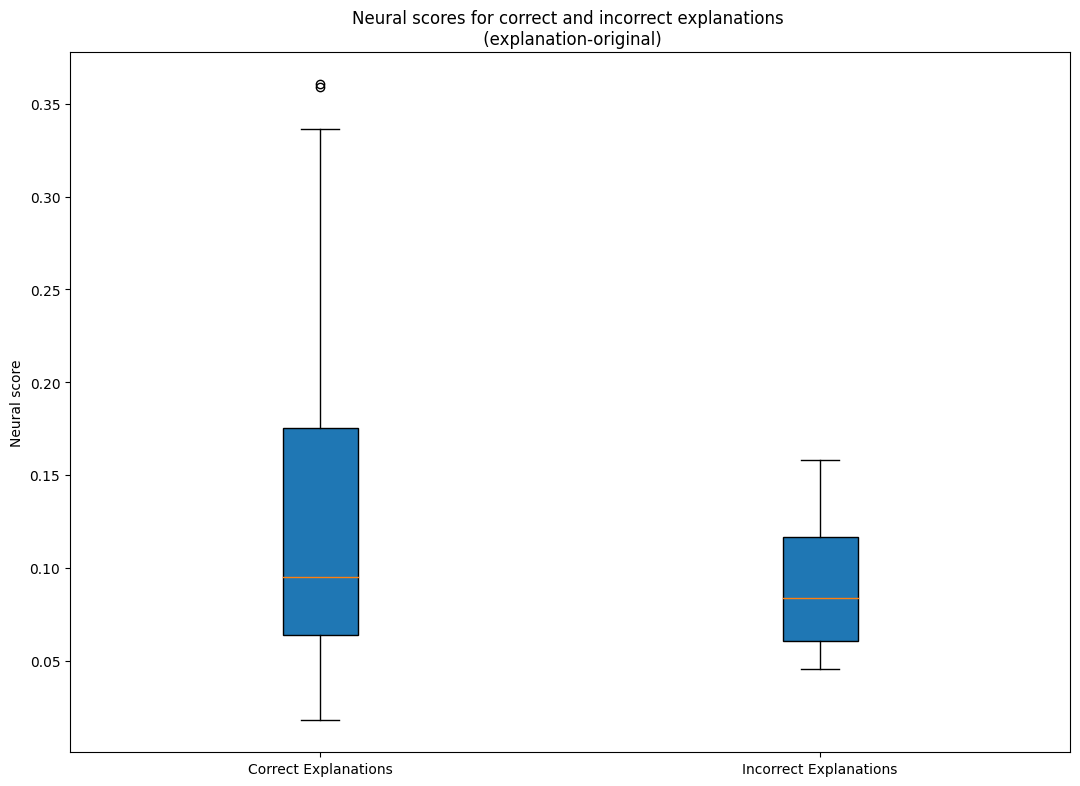

In [13]:
# Now we can try to find the threshold of the neural score that gives correct explanations, based on the qualitative evaluation

# Gather all neural scores where the explanation is correct
correct_explanation_1 = qualitative_results[qualitative_results['Correct explanation_1?'] == 1]['explanation-original_neural_score']
incorrect_explanations_1 = qualitative_results[qualitative_results['Correct explanation_1?'] == 0]['explanation-original_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_1, incorrect_explanations_1], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (explanation-original)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (label-explanation-original)')

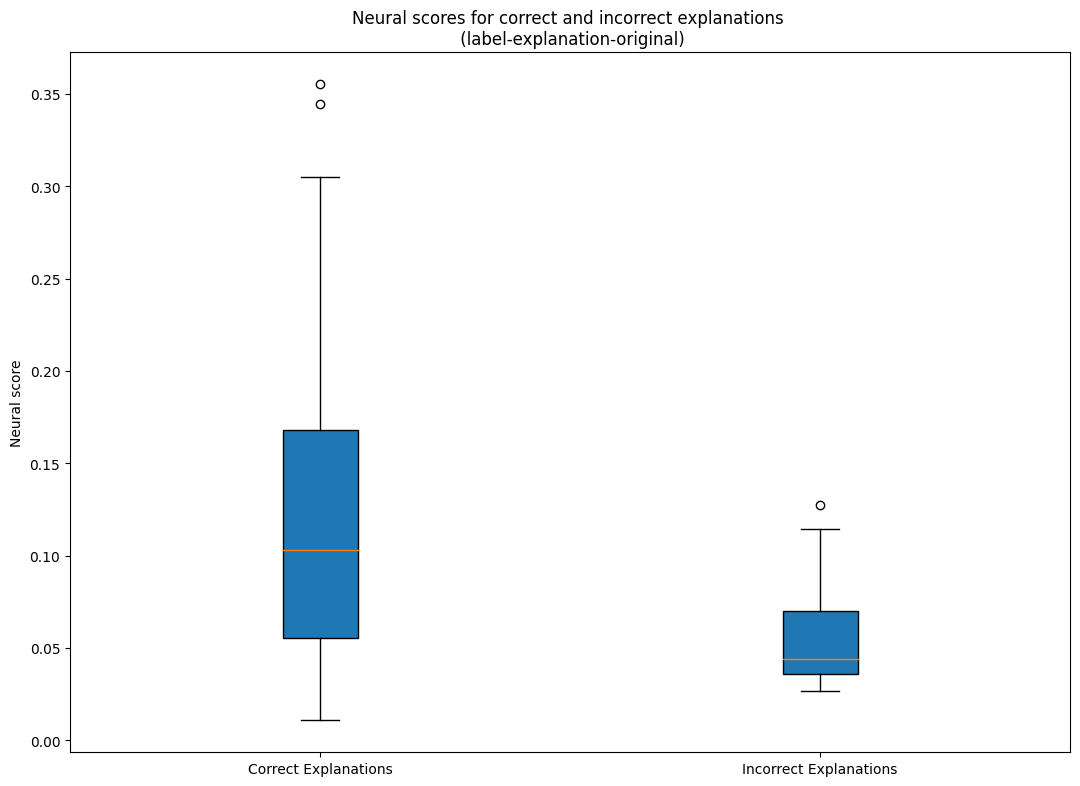

In [14]:
# Gather all neural scores where the explanation is correct
correct_explanation_2 = qualitative_results[qualitative_results['Correct explanation_2? '] == 1]['label-explanation-original_neural_score']
incorrect_explanations_2 = qualitative_results[qualitative_results['Correct explanation_2? '] == 0]['label-explanation-original_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_2, incorrect_explanations_2], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (label-explanation-original)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (explanation-custom)')

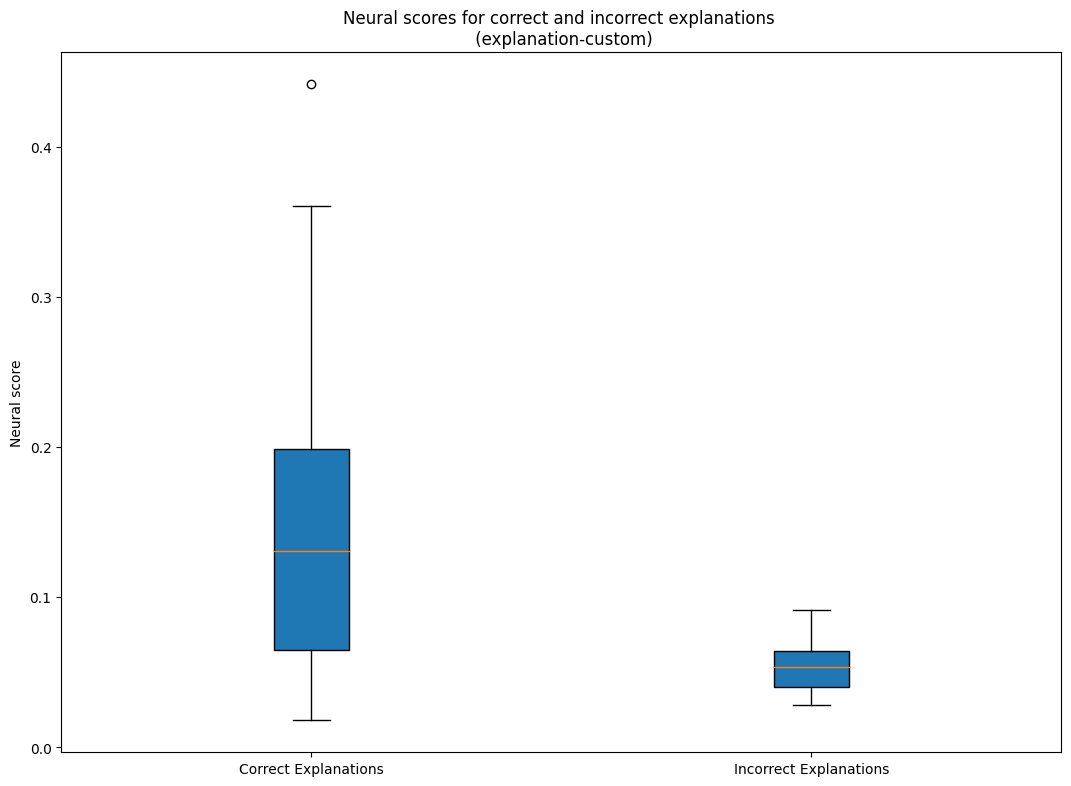

In [15]:
# Gather all neural scores where the explanation is correct
correct_explanation_3 = qualitative_results[qualitative_results['Correct explanation_3?'] == 1]['explanation-custom_neural_score']
incorrect_explanations_3 = qualitative_results[qualitative_results['Correct explanation_3?'] == 0]['explanation-custom_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_3, incorrect_explanations_3], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (explanation-custom)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (label-explanation-custom)')

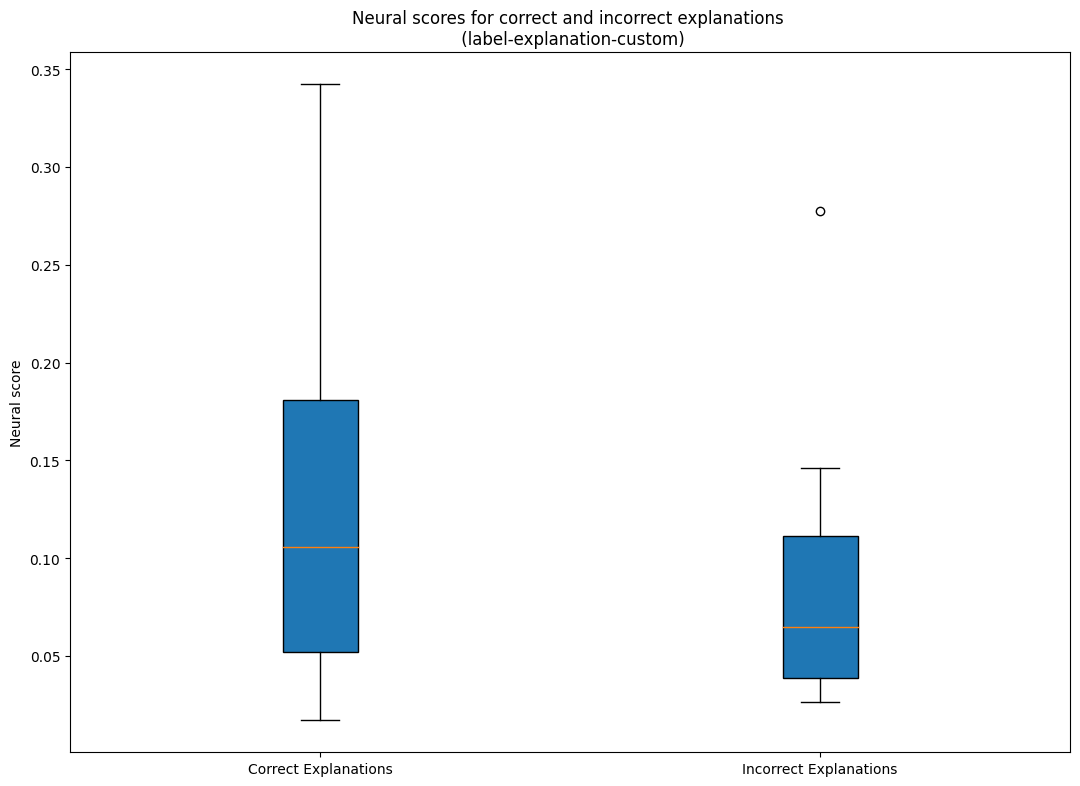

In [16]:
# Gather all neural scores where the explanation is correct
correct_explanation_4 = qualitative_results[qualitative_results['Correct explanation_4? '] == 1]['label-explanation-custom_neural_score']
incorrect_explanations_4 = qualitative_results[qualitative_results['Correct explanation_4? '] == 0]['label-explanation-custom_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_4, incorrect_explanations_4], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (label-explanation-custom)")

Correct explanations mean: 0.12692207537943262
Correct explanations sd: 0.08555196680050701
Incorrect explanations mean: 0.07201787515789473
Incorrect explanations sd: 0.04973247686106458


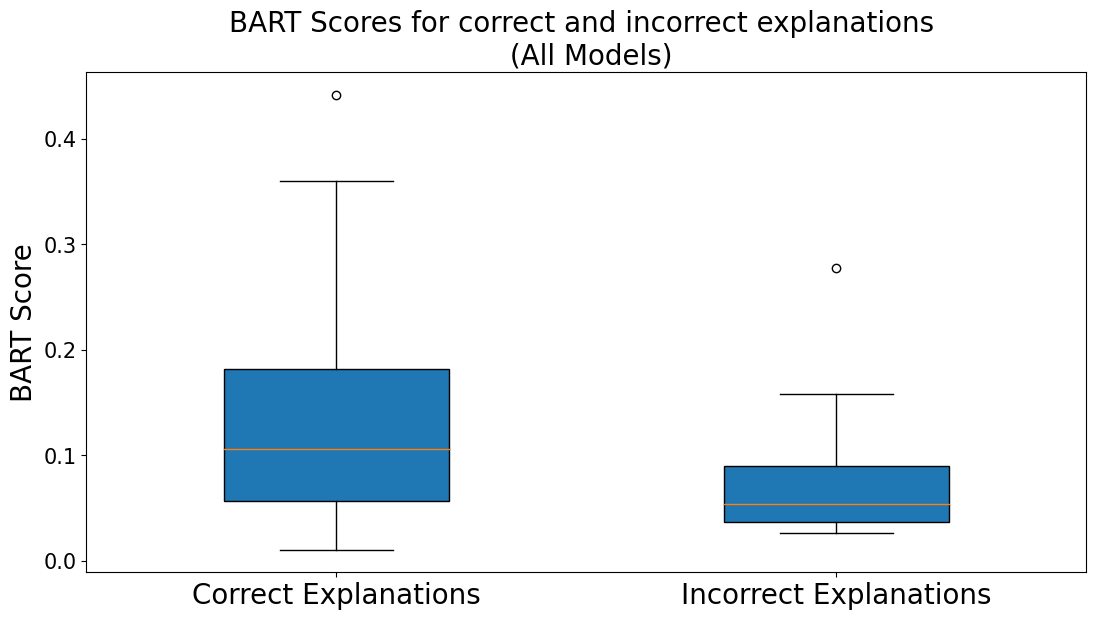

In [19]:
# Gather all neural scores where the explanation is correct, from all models
all_correct_explanations_neural_scores = pd.concat([correct_explanation_1, correct_explanation_2, correct_explanation_3, correct_explanation_4])
all_incorrect_explanations_neural_scores = pd.concat([incorrect_explanations_1, incorrect_explanations_2, incorrect_explanations_3, incorrect_explanations_4])

fig = plt.figure(figsize =(20, 10))
# Creating axes instance
ax = fig.add_axes([0, 0, 0.5, 0.5])
# Creating plot
bp = ax.boxplot([all_correct_explanations_neural_scores, all_incorrect_explanations_neural_scores], patch_artist = True, widths=(0.45, 0.45))

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'], fontsize=20)
plt.yticks(fontsize=15)

ax.set_ylabel('BART Score', fontsize=20)
 
# Adding title
plt.title("BART Scores for correct and incorrect explanations \n (All Models)", fontsize=20)

# Print means and sds for the neural scores
print('Correct explanations mean: ' + str(all_correct_explanations_neural_scores.mean()))
print('Correct explanations sd: ' + str(all_correct_explanations_neural_scores.std()))
print('Incorrect explanations mean: ' + str(all_incorrect_explanations_neural_scores.mean()))
print('Incorrect explanations sd: ' + str(all_incorrect_explanations_neural_scores.std()))